## Environment

In [57]:
import numpy as np

In [58]:
class Environment_Multiple_Contexts():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling

  def pull_features(self):
    x1 = np.random.binomial(1,1/3)
    x2 = np.random.binomial(1,1/2)
    if x1 == 1:
      i=0
    elif x2 == 1:
      i=1
    else:
      i=2
    return x1, x2, i

  # daily rewards
  def bidding_round(self, pulled_bid, i):
    clicks = int(np.random.normal(self.average_number_of_clicks[i](self.bids[pulled_bid]),self.noise_clicks[i]))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost[i](self.bids[pulled_bid]),self.noise_cost[i])                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0
    return reward_click, reward_cost

  def pricing_round(self, pulled_price, i): 
    reward_price = np.random.binomial(1,self.probabilities[i][pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [59]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [60]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

In [61]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    self.confidence[pulled_arm] = self.prices[pulled_arm]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[pulled_arm]))

## Advertising

In [62]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [63]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.ones(self.n_arms) * 1e3
    self.means_costs = np.ones(self.n_arms) * 1e3
    self.sigmas_clicks = np.ones(self.n_arms) 
    self.sigmas_costs = np.ones(self.n_arms) 
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    # we initialize the parameters of the kernel and the two GPs
    kernel_clicks = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
    kernel_costs = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
    self.gp_clicks = GaussianProcessRegressor(kernel = kernel_clicks, alpha = alpha_clicks**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer) 
    self.gp_costs = GaussianProcessRegressor(kernel = kernel_costs, alpha = alpha_costs**2, normalize_y = normalize_y, n_restarts_optimizer = n_restarts_optimizer) 
    self.plot = plot
    self.step = step
    self.step_delay = step_delay

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < self.step_delay or not(self.t % self.step):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1: 
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)  

      if self.plot:
        plt.figure()
        plt.title("Clicks:" + str(self.t))
        plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
        plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
        plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$n(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

        plt.figure()
        plt.title("Costs:" + str(self.t))
        plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
        plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
        plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$c(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution 
    samples = np.random.normal(self.means_clicks - self.means_costs, np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2))
    return np.argmax(samples)

In [64]:
class GPUCB_Learner(GPTS_Learner):
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms, arms, alpha_clicks, alpha_costs, normalize_y, step, step_delay, n_restarts_optimizer, plot)

  # returns index of the maximum UCB from the arm normal distribution (coefficient for CI of order 1-1/T: 3.0)
  def pull_arm(self):
    upper_bound = self.means_clicks - self.means_costs + 3.0*np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2)
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0]) 
    return pulled_arm

## Simulation

In [65]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [66]:
# generic
T = 365                                # horizon of experiment
n_experiments = 10                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [67]:
# pricing
n_prices = 5
prices = [[5,6,7,8,9],
          [3,4,5,6,7],
          [2,3,4,5,6]] # For every context we consider 5 diff prices
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.2,0.15,0.05,0.4,0.1],
              [0.25,0.15,0.1,0.1,0.2]])             # bernoulli distributions for the reward functions
opt_rate = [p[0][np.argmax(p[0]*prices[0])],
            p[1][np.argmax(p[1]*prices[1])],
            p[2][np.argmax(p[2]*prices[2])]]                 # optimal arm

for i in range(0,3):
    print("Pricing (optimal price) context ", str(i))
    print("idx: " + str(np.argmax(p[i]*prices[i])) + "  price: " + str(prices[i][np.argmax(p[i]*prices[i])]) + "  rate: " + str(opt_rate[i]) + "  price*rate: " + str(opt_rate[i]*prices[i][np.argmax(p[i]*prices[i])]))

Pricing (optimal price) context  0
idx: 3  price: 8  rate: 0.35  price*rate: 2.8
Pricing (optimal price) context  1
idx: 3  price: 6  rate: 0.4  price*rate: 2.4000000000000004
Pricing (optimal price) context  2
idx: 4  price: 6  rate: 0.2  price*rate: 1.2000000000000002


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 59  bid: 0.595959595959596  clicks-costs: 9.57619827197513
Advertising (optimal bid):
idx: 49  bid: 0.494949494949495  clicks-costs: 34.47657532493205


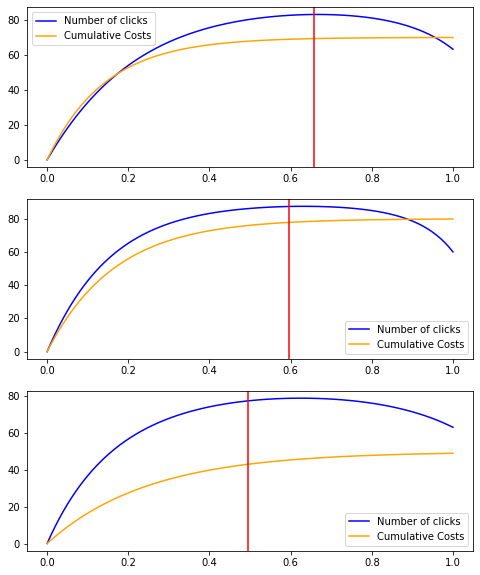

In [68]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = [3, 2.5, 3]
sigma_costs = [3, 2.5, 3]

params_clicks = [[100, 4, 3, 3],
                 [95,  6, 5, 3],
                 [100, 5, 4, 2]]
params_costs = [[70, 7],
                [80, 6],
                [50, 4]]
def clicks(x, params=[100, 4, 3, 3]):
  return params[0] * (1.0 - np.exp(-params[1]*x+params[2]*x**params[3]))

def costs(x, params=[70, -7]):
  return params[0] * (1.0 - np.exp(-params[1]*x))


opt_bid = np.zeros(3)
for i in range(0,3):
    opt_bid[i] = bids[np.argmax(opt_rate[i]*prices[i][np.argmax(p[i]*prices[i])]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))]

fig, ax = plt.subplots(3, figsize=(8,10))
for i in range(0, 3):
    ax[i].plot(bids,clicks(bids, params_clicks[i]),'blue',bids, costs(bids, params_costs[i]),'orange')
    ax[i].legend(["Number of clicks", "Cumulative Costs"])
    ax[i].axvline(opt_bid[i],c='red')
    print("Advertising (optimal bid):")
    print("idx: " + str(np.argmax(opt_rate[i]*prices[i][np.argmax(p[i]*prices[i])]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))) + "  bid: " + str(opt_bid[i]) + "  clicks-costs: " + str(clicks(opt_bid[i], params_clicks[i])-costs(opt_bid[i], params_costs[i])))

In [69]:
# Function wrapper to be able to pass to environment
def clicks1(x):
    return clicks(x, params_clicks[0])
def clicks2(x):
    return clicks(x, params_clicks[1])
def clicks3(x):
    return clicks(x, params_clicks[2])

In [70]:
# Function wrapper to be able to pass to environment
def costs1(x):
    return costs(x, params_costs[0])
def costs2(x):
    return costs(x, params_costs[1])
def costs3(x):
    return costs(x, params_costs[2])

In [71]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [72]:
env = Environment_Multiple_Contexts(n_arms = n_prices,
                                        probabilities = p,
                                        bids = bids,
                                        average_number_of_clicks = [clicks1, clicks2, clicks3],
                                        average_cum_daily_cost = [costs1, costs2, costs3],
                                        noise_clicks = sigma_clicks,
                                        noise_cost = sigma_costs)

env.pull_features()

(0, 0, 2)

In [ ]:
# experiments
gpts_rewards_per_experiment = [[],[],[]]
gpucb_rewards_per_experiment = [[],[],[]]

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment_Multiple_Contexts(n_arms = n_prices,
                                        probabilities = p,
                                        bids = bids,
                                        average_number_of_clicks = [clicks1, clicks2, clicks3],
                                        average_cum_daily_cost = [costs1, costs2, costs3],
                                        noise_clicks = sigma_clicks,
                                        noise_cost = sigma_costs)
  # Create one pricing and advert. learner per context with the diff. prices and noises.
  pricing_learners_gpts = [TS_Pricing_Learner(n_arms = n_prices, prices = prices[0]),
                           TS_Pricing_Learner(n_arms = n_prices, prices = prices[1]),
                           TS_Pricing_Learner(n_arms = n_prices, prices = prices[2])]
  pricing_learners_gpucb =[TS_Pricing_Learner(n_arms = n_prices, prices = prices[0]),
                           TS_Pricing_Learner(n_arms = n_prices, prices = prices[1]),
                           TS_Pricing_Learner(n_arms = n_prices, prices = prices[2])]
  gpts_learners = [GPTS_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[0], alpha_costs = sigma_costs[0], 
                              step = 1, normalize_y = True,plot = False, step_delay = 0), #n_restarts_optimizer = 9
                  GPTS_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[1], alpha_costs = sigma_costs[1], 
                              step = 1, normalize_y = True,plot = False, step_delay = 0), #n_restarts_optimizer = 9
                  GPTS_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[2], alpha_costs = sigma_costs[2], 
                              step = 1, normalize_y = True,plot = False, step_delay = 0) #n_restarts_optimizer = 9
                 ]
  gpucb_learners = [GPUCB_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[0], alpha_costs = sigma_costs[0],
                                step = 1, normalize_y = True, step_delay = 0), #plot = True, n_restarts_optimizer = 9,
                   GPUCB_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[1], alpha_costs = sigma_costs[1],
                                step = 1, normalize_y = True, step_delay = 0), #plot = True, n_restarts_optimizer = 9,
                   GPUCB_Learner(n_arms = n_bids, arms = bids, alpha_clicks = sigma_clicks[2], alpha_costs = sigma_costs[2],
                                step = 1, normalize_y = True, step_delay = 0) #plot = True, n_restarts_optimizer = 9,
                  ]

  gpts_daily_pricing_rewards = [np.array([]),np.array([]),np.array([])]
  gpucb_daily_pricing_rewards = [np.array([]),np.array([]),np.array([])]

  # 4.2:
  # run basic algorithm for 2 weeks, for every person (n total) observe also x1,x2
    # depending on x1 and x2 we use the corresponding environment variables: click and cost fct and sigmas, price probs.
    # REVIEW: use same prices for all classes (i.e. as in step 3) 
  # after 2 weeks, run context-generator algorithm (n tuples: [x1,x2,buy*price]) <=> classification algorithm that maps (x1,x2)->(a,b,c,... M classes, since we don't know the actual ones)
    # REVIEW: how? split condition in slides?
  # for each day (for 2 weeks):
    # We create M bidding learners and M pricing learners
    # pull M bids -> mapped into 3 bids for the observation purposes
    # observe a certain amount of clicks (clicks1 [1,.], clicks2 [0,1], clicks3 [0,0]) -> mapped into clicks1, ..., clicksM by the context classification algorithm
      # REVIEW: Regarding context class. algo:
      # for every person (n total) observe x1 and x2:
        # [1,1]->1  [0,1]->2 [1,0]->1, [0,0]->3 => clicks[1,1] = 1/2*clicks1, clicks[1,0] = 1/2*clicks1
        # [1,:]->1 [0,:]->2,3 => clicks[0,:] = clicks2 + clicks3
    # observe a certain amount of costs (costs1 [1,.], costs2 [0,1], costs3 [0,0]) -> mapped into costs1, ..., costsM by the context classification algorithm
      # same as clicks
    # update the M bidding_learners
    
    # for each class/context (1,...,M):
      # for each click:
        # pull a price
        # observe acquisition or not
        # update correspondin pricing_learner
        
    # after 2 weeks, update context-generator algorithm

  # reward: sum(rate[i]*price[i]*clicks[i] - costs[i])

  # First two weeks
  for t in range(0, 14):
    # GPTS
    for i in range(3): # Each context
        pulled_bid_ts = gpts_learners[i].pull_arm()  # pull bid for each context
        reward_click_ts, reward_cost_ts = env.bidding_round(pulled_bid_ts, i)
        gpts_learners[i].update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])
        for k in range(reward_click_ts):
          pulled_price = pricing_learners_gpts[i].pull_arm()
          reward_price = env.pricing_round(pulled_price, i)
          pricing_learners_gpts[i].update(pulled_price, reward_price)
        gpts_daily_pricing_rewards[i] = np.append(gpts_daily_pricing_rewards[i], np.sum(pricing_learners_gpts[i].collected_rewards[-reward_click_ts:]))
  
  # Continue after first classification of context-generation algorithm
  for t in range(14,T):  # cycle on time horizon
   pass
    
  for i in range(3):
    gpts_rewards_per_experiment[i].append(gpts_daily_pricing_rewards[i] - gpts_learners[i].collected_costs)
    


In [ ]:
# Plot cum regret for all three contexts
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
colors_context = ['b', 'r', 'g']
for i in range(3):
    opt = opt_rate[i]*prices[i][np.argmax(p[i]*prices[i])]*clicks(opt_bid[i], params_clicks[i]) - costs(opt_bid[i], params_costs[i])
    plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment[i], axis = 0)), colors_context[i]+'.')
    plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment[i], axis = 0)), colors_context[i]+'-')
plt.legend(["GPTS","GPUCB"])
plt.show